In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt
import os


In [46]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
from utils import *
from dataset_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data', 'results', 'data/lenses']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [6]:
model=None
torch.cuda.empty_cache()

In [7]:
access_token = input("Enter your access token: ")

In [8]:
# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "meta-llama/Llama-2-7b-chat-hf"
# model_name = "huggyllama/llama-7b"
# load tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
tokenizer.padding_side = "left"
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

## Generate data

In [62]:
dataset = load_data_set('FreebaseStatements') # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
max_new_tokens = 10
batch_size = 64

In [63]:
lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

change_format(dataset, lie_format, truth_format)

In [64]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset FreebaseStatements: 1952


  0%|          | 0/30 [00:00<?, ?it/s]/root/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
31it [00:35,  1.14s/it]                        
31it [00:00, 416.09it/s]              


Success rate when generating truths: 51.18%


31it [00:36,  1.18s/it]                        
31it [00:00, 452.44it/s]              


Success rate when generating lies:   83.76%
Overlap: 37.04%


## Get the hidden states for all generated tokens

In [65]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)
success = dataset['success']
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


100%|██████████| 12/12 [00:17<00:00,  1.48s/it]


In [66]:
dataset['hidden_states_lie'].shape

torch.Size([32, 723, 11, 4096])

## Tuned lens setup

In [67]:
# get tuned lenses

file = 'https://huggingface.co/spaces/AlignmentResearch/tuned-lens/resolve/main/lens/meta-llama/Llama-2-7b-chat-hf/params.pt?download=true'

# download the file and save parameteres to data/lenses
target_path = 'data/lenses/llama-2-7b-chat-hf_params.pt'
if not os.path.exists(target_path):
    os.system(f"wget {file} -O {target_path} -q")
    
raw_lenses = torch.load(target_path)

In [68]:

lenses = []

for i in range(model.config.num_hidden_layers):
    lens = torch.nn.Linear(in_features=model.config.hidden_size, out_features=model.config.hidden_size, bias=True)
    lens.weight = torch.nn.Parameter(raw_lenses[f'{i}.weight'].to(torch.float16))
    lens.bias = torch.nn.Parameter(raw_lenses[f'{i}.bias'].to(torch.float16))
    lens = lens.to(device)
    lenses.append(lens)

# linear layer that has zero matrix as weight and zeros as bias
lens = torch.nn.Linear(in_features=model.config.hidden_size, out_features=model.config.hidden_size, bias=False)
lens.weight = torch.nn.Parameter(torch.zeros([model.config.hidden_size, model.config.hidden_size], dtype=torch.float16).to(device))
lens = lens.to(device)
lenses.append(lens)

# pop first layer
_ = lenses.pop(0)

In [69]:
for i in range(32):
    print(lenses[i].weight.pow(2).sum().item())

6.6875
7.66015625
8.375
8.8515625
9.0859375
9.4375
9.8671875
9.875
9.9609375
10.046875
10.03125
9.90625
9.65625
9.40625
9.1953125
8.9375
8.15625
7.6015625
7.55859375
7.390625
7.4921875
7.296875
7.1484375
6.61328125
6.1328125
5.51171875
4.60546875
3.7421875
2.890625
2.009765625
1.0263671875
0.0


# Probability of predicted token over layers

In [70]:
# probability of predicted token over layers
num_samples = len(dataset['answer_lie'])
prob_truth, prob_lie = torch.zeros([num_modules, num_samples, len(token_positions)-1]), torch.zeros([num_modules, num_samples, len(token_positions)-1])

for i in tqdm(range(num_modules)):

    for idx, tp in enumerate(token_positions[:-1]):

        unembedded_truth = unembed_tuned_lens(model, dataset['hidden_states_truth'][i, :, tp, :], lens=lenses[i])
        unembedded_lie = unembed_tuned_lens(model, dataset['hidden_states_lie'][i, :, tp, :], lens=lenses[i])

        # predicted token is the next token in the sequence
        predicted_truth_token = dataset['output_tokens_truth']['input_ids'][:,tp+1]
        predicted_lie_token = dataset['output_tokens_lie']['input_ids'][:,tp+1]
      
        prob_truth[i, :, idx] = unembedded_truth.softmax(dim=1)[torch.arange(num_samples), predicted_truth_token]
        prob_lie[i, :, idx] = unembedded_lie.softmax(dim=1)[torch.arange(num_samples), predicted_lie_token]

100%|██████████| 32/32 [02:08<00:00,  4.01s/it]


In [71]:
prob_truth.shape

torch.Size([32, 723, 10])

In [72]:
def plot_prob(prob_t, prob_l, token_pos, dataset_name, plot_all_curves=False):
    # plot
    fig, ax = plt.subplots(figsize=(10, 5))

    if plot_all_curves:
        alpha = prob_t.shape[1]/42600.0
        ax.plot(prob_t, color='tab:blue', alpha=alpha)
        ax.plot(prob_l, color='tab:orange', alpha=alpha)
    ax.plot(prob_t.median(axis=1).values, color='tab:blue', label='truth median')
    ax.plot(prob_l.median(axis=1).values, color='tab:orange', label='lie median')
    ax.plot(prob_t.mean(axis=1), color='tab:blue', label='truth mean', linestyle='--')
    ax.plot(prob_l.mean(axis=1), color='tab:orange', label='lie mean', linestyle='--')

    ax.grid()
    ax.set_xlabel("Layer")
    ax.set_ylabel("Probability")
    ax.set_title(f"Probabilities for {dataset_name} (token {token_pos})")
    ax.legend()

    fig.savefig(f"plots/probability_tuned_lens_predicted_token_{dataset_name}_token_pos_{token_pos}.png")

In [73]:
prob_truth.shape

torch.Size([32, 723, 10])

In [74]:
token_positions

range(-11, 0)

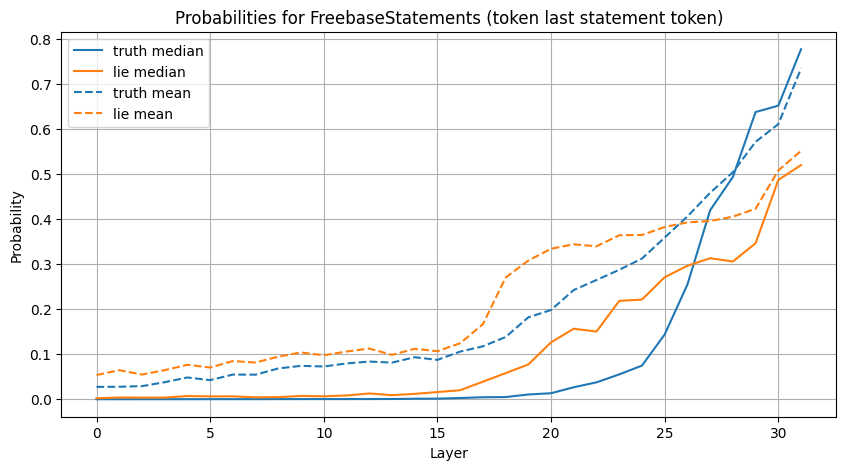

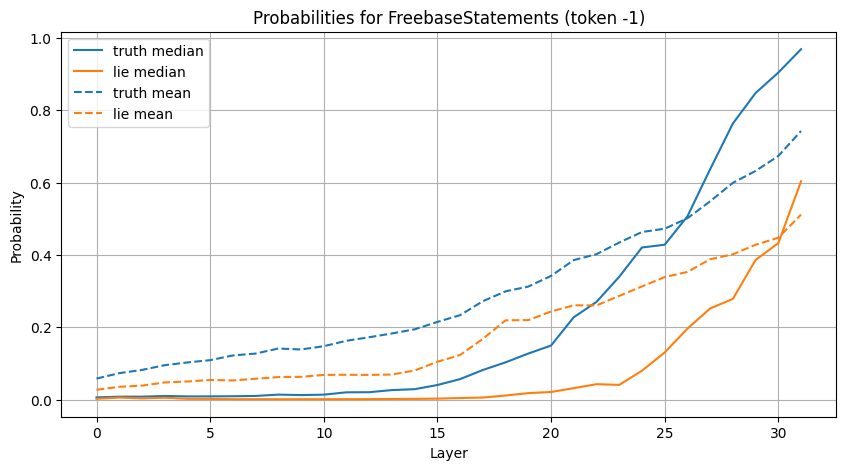

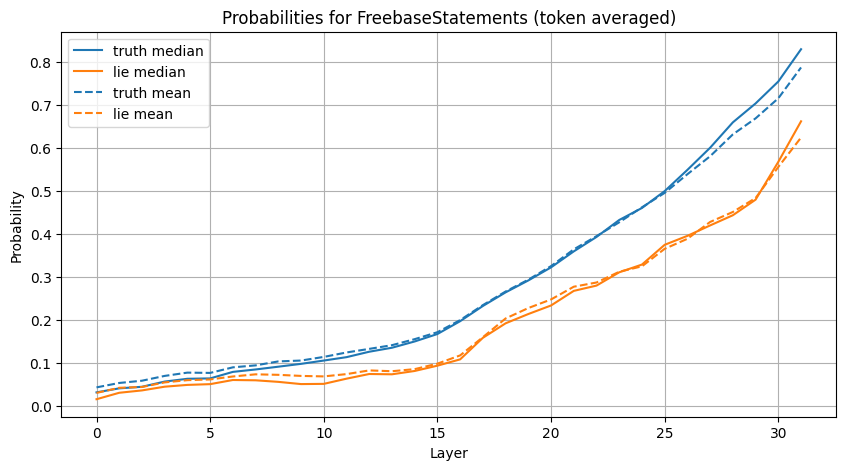

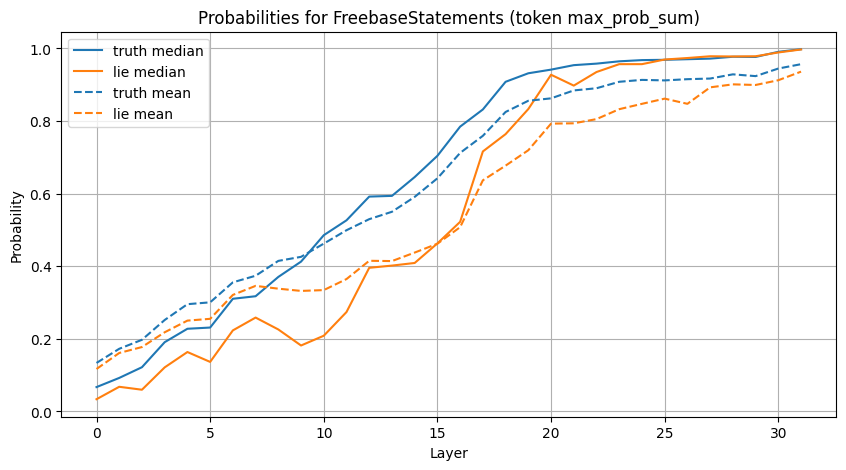

In [75]:
# plot for different token positions

# last token of statement
token_pos = 0
plot_prob(prob_truth[:,:,token_pos], prob_lie[:,:,token_pos], 'last statement token', dataset['dataset_name'])

# last token of answer
token_pos = -1
plot_prob(prob_truth[:,:,token_pos], prob_lie[:,:,token_pos], token_pos, dataset['dataset_name'])

# averaged over all tokens
token_pos = "averaged"
plot_prob(prob_truth.mean(axis=2), prob_lie.mean(axis=2), token_pos, dataset['dataset_name'])

# max_prob
token_pos = "max_prob_sum"

prob_sum_truth = prob_truth.sum(axis=0)
prob_sum_lie = prob_lie.sum(axis=0)

token_pos_truth = prob_sum_truth.argmax(dim=1)
token_pos_lie = prob_sum_lie.argmax(dim=1)

plot_prob(prob_truth[:,range(num_samples),token_pos_truth], prob_lie[:,range(num_samples),token_pos_lie], token_pos, dataset['dataset_name'])


In [76]:
random_idx = np.random.randint(0, num_samples, 5)


In [77]:
random_idx = np.random.randint(0, num_samples, 5)
org_data = dataset['org_data'][success]
tp=token_positions[0]
stride=4
for i in random_idx:
    print('#'*20)
    print(org_data[i])
    # predicted token is the next token in the sequence
    predicted_truth_token = dataset['output_tokens_truth']['input_ids'][:,tp+1]
    print(f"predicted: {tokenizer.decode(predicted_truth_token[i])}")

    for l in range(0,num_modules, stride):

        unembedded_tuned = unembed_tuned_lens(model, dataset['hidden_states_truth'][l, i, tp, :], lens=lenses[l])
        unembedded = unembed(model, dataset['hidden_states_truth'][l, i, tp, :])
        argmax_tuned = unembedded_tuned.argmax()
        argmax = unembedded.argmax()
        print(f"l_{l}: tuned_lens: {tokenizer.decode(argmax_tuned)}\tlogit_lens: {tokenizer.decode(argmax)}")
    

####################
Colonel Gaddafi was killed in the town of
predicted: Sir
l_0: tuned_lens: the	logit_lens: пута
l_4: tuned_lens: B	logit_lens: Hinweis
l_8: tuned_lens: B	logit_lens: ﬁ
l_12: tuned_lens: South	logit_lens: Bedeut
l_16: tuned_lens: K	logit_lens: Bedeut
l_20: tuned_lens: Lib	logit_lens: Lib
l_24: tuned_lens: Lib	logit_lens: Lib
l_28: tuned_lens: Sir	logit_lens: Sir
####################
The capital of the principality of Lichtenstein is
predicted: V
l_0: tuned_lens: a	logit_lens: nt
l_4: tuned_lens: a	logit_lens: nt
l_8: tuned_lens: 	logit_lens: zew
l_12: tuned_lens: a	logit_lens: üst
l_16: tuned_lens: actually	logit_lens: indeed
l_20: tuned_lens: 	logit_lens: capital
l_24: tuned_lens: 	logit_lens: Lie
l_28: tuned_lens: V	logit_lens: V
####################
Paraguay has its longest land border with the country
predicted: of
l_0: tuned_lens: .	logit_lens: wide
l_4: tuned_lens: of	logit_lens: hood
l_8: tuned_lens: is	logit_lens: arch
l_12: tuned_lens: of	logit_lens: wide
l_

l_20: tuned_lens: Belg	logit_lens: Belg
l_24: tuned_lens: the	logit_lens: Belg
l_28: tuned_lens: the	logit_lens: which
####################
The 1951 classic movie The Day The Earth Stood Still was directed by
predicted: Robert
l_0: tuned_lens: the	logit_lens: means
l_4: tuned_lens: the	logit_lens: ék
l_8: tuned_lens: John	logit_lens: weis
l_12: tuned_lens: John	logit_lens: Kreis
l_16: tuned_lens: John	logit_lens: Bedeut
l_20: tuned_lens: al	logit_lens: Sci
l_24: tuned_lens: al	logit_lens: direct
l_28: tuned_lens: Robert	logit_lens: reg


In [78]:
for i in random_idx:
    print('#'*20)
    print(org_data[i])
    # predicted token is the next token in the sequence
    predicted_truth_token = dataset['output_tokens_lie']['input_ids'][:,tp+1]
    print(f"predicted: {tokenizer.decode(predicted_truth_token[i])}")

    for l in range(0,num_modules, stride):

        unembedded_tuned = unembed_tuned_lens(model, dataset['hidden_states_lie'][l, i, tp, :], lens=lenses[l])
        unembedded = unembed(model, dataset['hidden_states_lie'][l, i, tp, :])
        argmax_tuned = unembedded_tuned.argmax()
        argmax = unembedded.argmax()
        print(f"l_{l}: tuned_lens: {tokenizer.decode(argmax_tuned)}\tlogit_lens: {tokenizer.decode(argmax)}")
    

####################
Colonel Gaddafi was killed in the town of
predicted: Beng
l_0: tuned_lens: the	logit_lens: пута
l_4: tuned_lens: B	logit_lens: Hinweis
l_8: tuned_lens: B	logit_lens: ﬁ
l_12: tuned_lens: South	logit_lens: ri
l_16: tuned_lens: T	logit_lens: Außer
l_20: tuned_lens: B	logit_lens: Lib
l_24: tuned_lens: Lib	logit_lens: Lib
l_28: tuned_lens: Sir	logit_lens: Tri
####################
The capital of the principality of Lichtenstein is
predicted: _
l_0: tuned_lens: a	logit_lens: nt
l_4: tuned_lens: a	logit_lens: hing
l_8: tuned_lens: 	logit_lens: zew
l_12: tuned_lens: a	logit_lens: URL
l_16: tuned_lens: _	logit_lens: nt
l_20: tuned_lens: L	logit_lens: actually
l_24: tuned_lens: L	logit_lens: Lie
l_28: tuned_lens: "	logit_lens: Tim
####################
Paraguay has its longest land border with the country
predicted: of
l_0: tuned_lens: .	logit_lens: wide
l_4: tuned_lens: of	logit_lens: hood
l_8: tuned_lens: ,	logit_lens: uvud
l_12: tuned_lens: of	logit_lens: wide
l_16: tuned_l